In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

Скачайте файлы train.csv, test.csv, sample_submission.csv в папку с этим ноутбуком

## Функция для формирования посылки

In [4]:
from datetime import datetime, timedelta

# На вход подается массив размера (test.shape[0], 2)
def submit(preds):
    n = datetime.now() + timedelta(hours=3)
    submission = pd.read_csv('sample_submission.csv')
    submission['TARGET'] = preds[:, 1]
    submission.to_csv('submission ({0}).csv'.format(n.strftime("%d-%m-%Y %H:%M")), index=0)

## Загрузка данных

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

labels = train['TARGET']
train.drop(['TARGET', 'ID'], axis=1, inplace=1)
test.drop(['ID'], axis=1, inplace=1)

print train.shape
print test.shape

(76020, 369)
(75818, 369)


In [6]:
train.head(10)

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,2,23,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,39205.170000
1,2,34,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,49278.030000
2,2,23,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,67333.770000
3,2,37,0,195,195,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,64007.970000
4,2,39,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,117310.979016
5,2,23,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,87975.750000
6,2,27,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,94956.660000
7,2,26,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,251638.950000
8,2,45,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,101962.020000
9,2,25,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,356463.060000


In [7]:
train.dtypes.value_counts()

int64      258
float64    111
dtype: int64

In [8]:
labels.value_counts()

0    73012
1     3008
Name: TARGET, dtype: int64

Классы сильно несбалансированы!

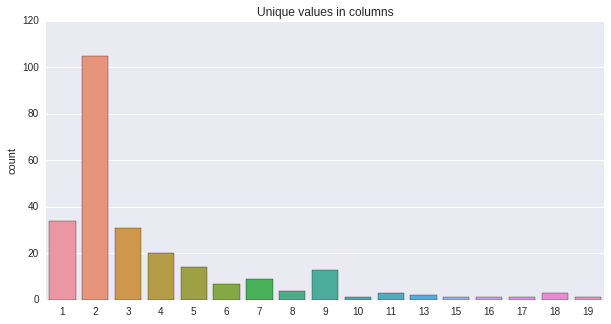

In [9]:
plt.figure(figsize=(10, 5))
sns.countplot(sorted([train[col].nunique() for col in train])[:250])
plt.title('Unique values in columns')

Примерно ~35 колонок содержат одно уникальное значение, поэтому их можно удалить

Можно заметить, что в данных очень много нулей. Посмотрим насколько много:

In [10]:
zeros_share = (train == 0).sum().sum() * 1. / np.prod(train.shape)
print 'Нулей: {0:0.2f}%'.format(100 * zeros_share)

Нулей: 90.90%


In [8]:
#print (train == 0).sum(axis=0)
#print np.prod(train.shape)
#print (train == 0).sum().sort_values()
#print train.shape[1]
#print (train == 0).sum(axis=1).sort_values()
#print train.shape[1]
#zero_counts = (train == 0).sum(axis=1).sort_values() * 1. / train.shape[1]


Примерно в 2/3 колонок нулей больше 95%!

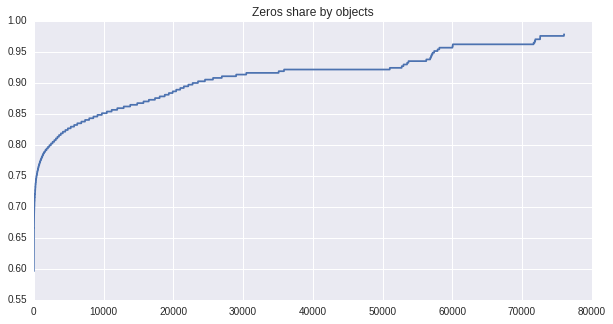

In [11]:
zeros_by_objects = (train == 0).sum(axis=1).sort_values() * 1. / train.shape[1]
plt.figure(figsize=(10, 5))
plt.plot(range(train.shape[0]), zeros_by_objects)
_ = plt.title('Zeros share by objects')

Почти во всех объектах нулей больше 75%, в половине - больше 90%. Так как у нас много признаков и они очень разреженные, то можно сделать вывод, что нули - это отсутствие информации о данном объекте. Например, человек никогда не брал вкладов и тогда признаки, отвечающие за вклады будут у него отсутствовать. Из этого можно извлечь информацию

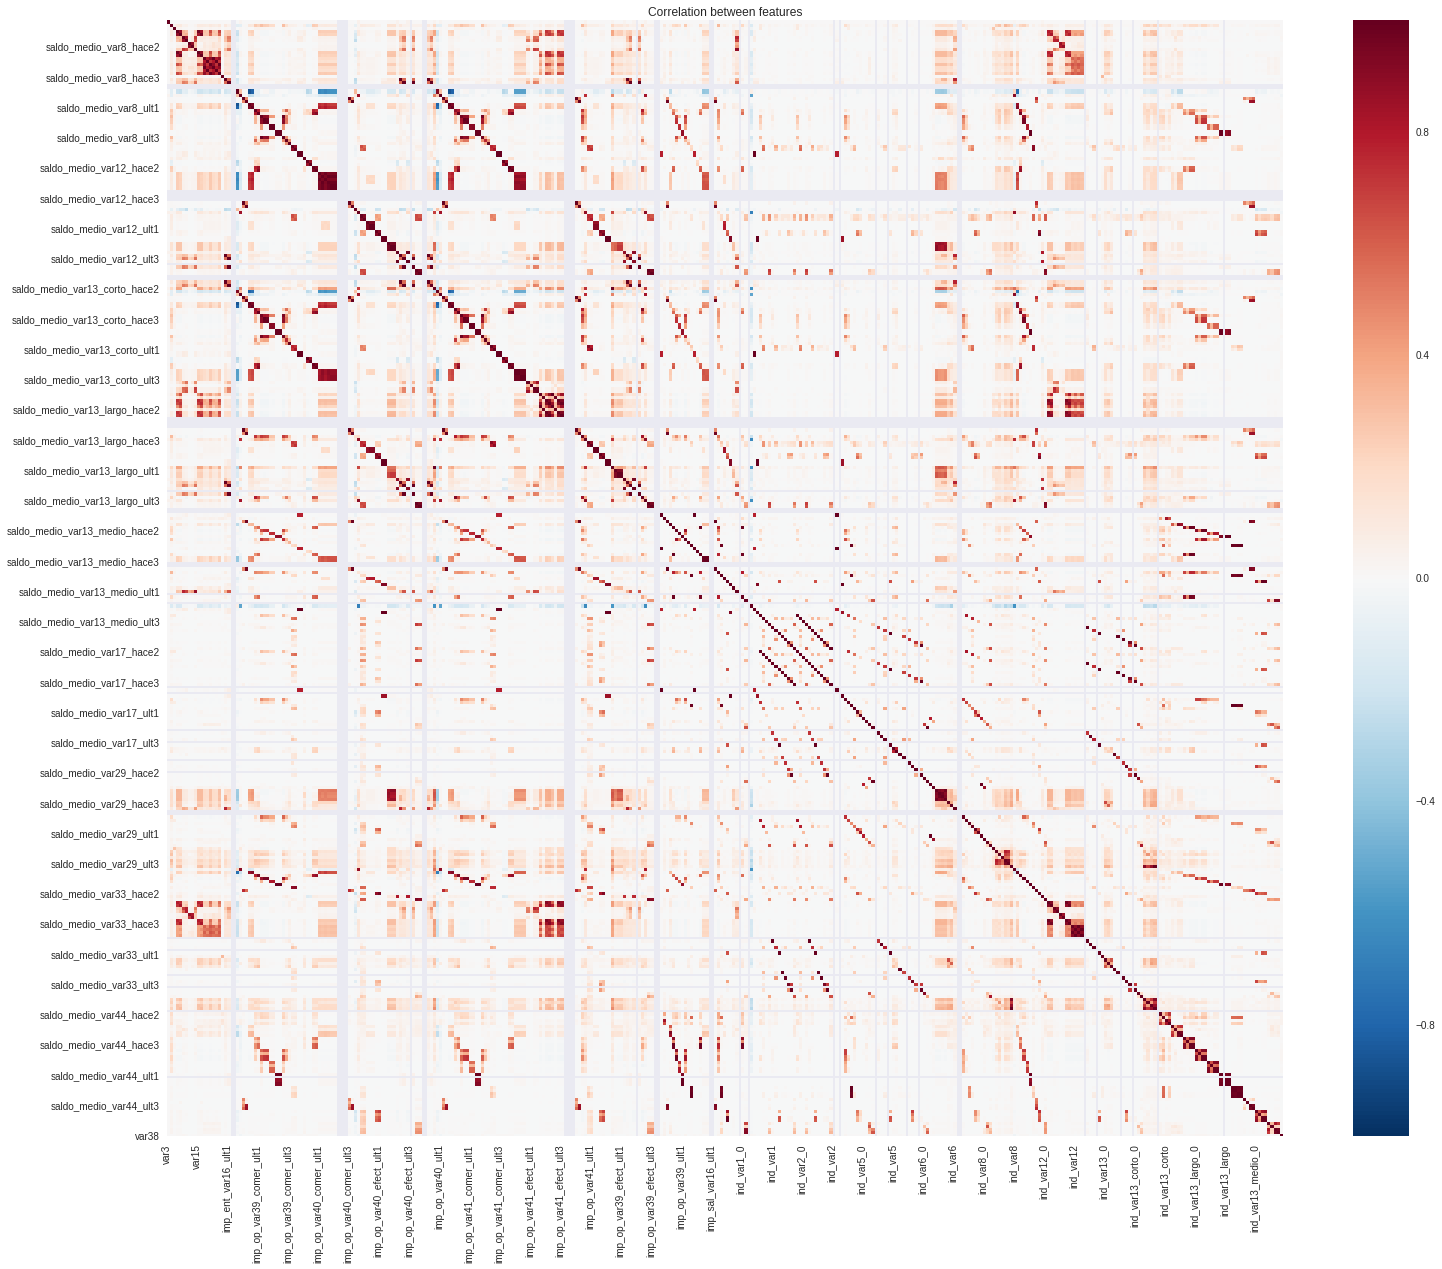

In [93]:
corrs = train.corr()

plt.figure(figsize=(25, 20))
sns.heatmap(corrs)
_ = plt.xticks(range(0, train.shape[1], 10))
_ = plt.yticks(range(0, train.shape[1], 10))
plt.title('Correlation between features')

Как можно видеть, некоторые признаки довольно сильно скоррелированны, причем они расположены группами

In [12]:
unique_values = np.array([train[col].nunique() for col in train])
test.drop(train.columns[unique_values == 1], axis=1, inplace=1)
train.drop(train.columns[unique_values == 1], axis=1, inplace=1)

In [13]:
from itertools import combinations

features_duplicates = set()
visited_cols = set()

for col1 in train:
    visited_cols.add(col1)
    for col2 in train:
        if col2 in visited_cols or col2 in features_duplicates:
            continue
        if np.array_equal(train[col1], train[col2]):
            features_duplicates.add(col2)
            
print 'Дублирующихся признаков: {0}'.format(len(features_duplicates))

Дублирующихся признаков: 29


Оказывается среди коррелирующих признаков есть много дубликатов. Их можно удалить!

In [14]:
train.drop(features_duplicates, axis=1, inplace=1)
test.drop(features_duplicates, axis=1, inplace=1)

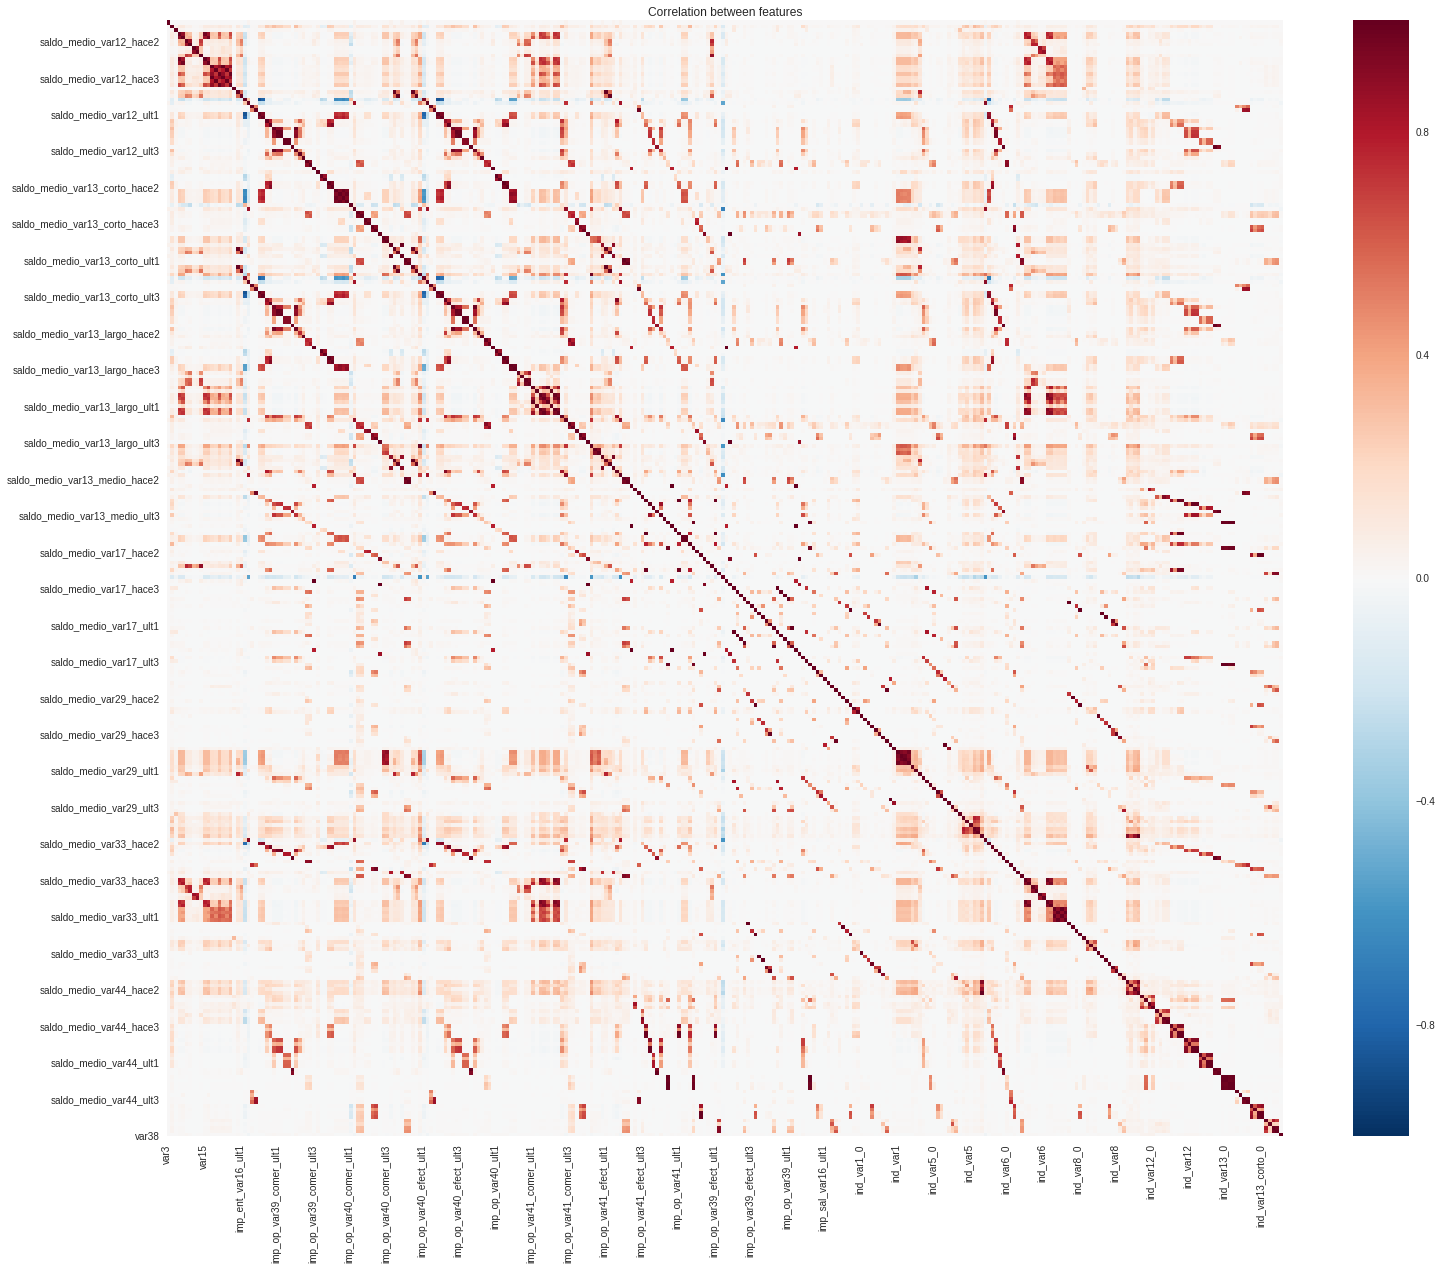

In [13]:
corrs = train.corr()

plt.figure(figsize=(25, 20))
sns.heatmap(corrs)
_ = plt.xticks(range(0, train.shape[1], 10))
_ = plt.yticks(range(0, train.shape[1], 10))
plt.title('Correlation between features')

### Взглянем на некоторые признаки

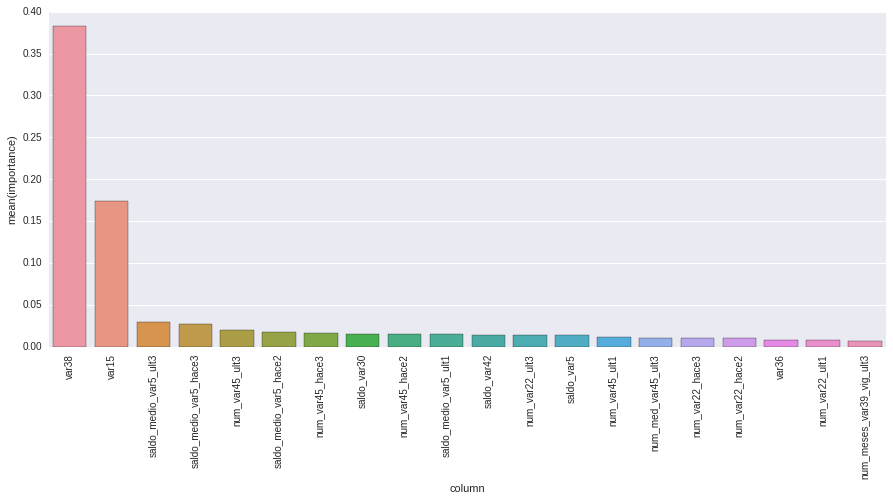

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(train, labels)
importances = pd.DataFrame({'column':train.columns, 'importance':rf.feature_importances_}).sort_values(by='importance', ascending=0)
plt.figure(figsize=(15, 6))
sns.barplot(x='column', y='importance', data=importances.iloc[:20])
_ = plt.xticks(rotation=90)

У двух признаков подозрительно большая важность, посмотрим ближе на них

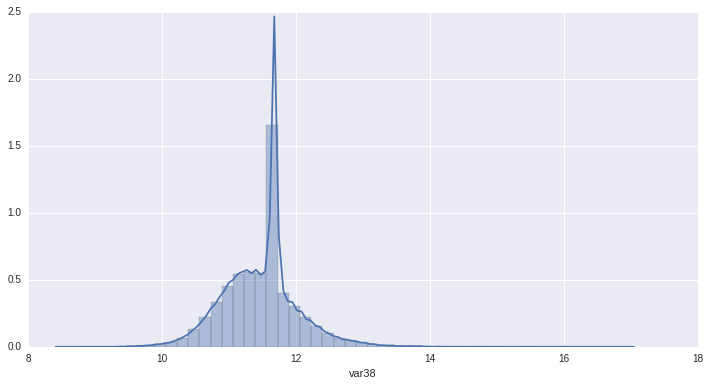

In [16]:
plt.figure(figsize=(12, 6))
sns.distplot(np.log1p(train['var38']))

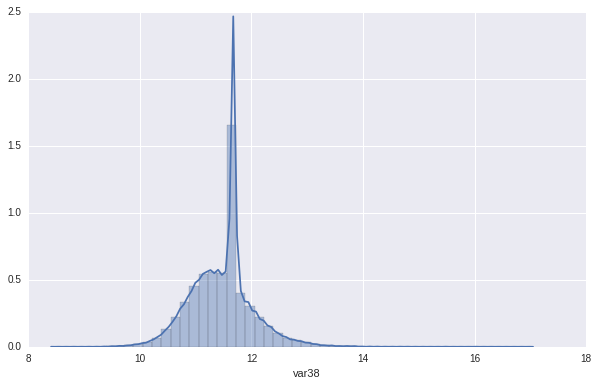

In [99]:
plt.figure(figsize=(10, 6))
sns.distplot(np.log1p(train['var38']))

In [17]:
train['var38'].value_counts().iloc[:10]

117310.979016    14868
451931.220000       16
463625.160000       12
288997.440000       11
104563.800000       11
236690.340000        8
104644.410000        7
125722.440000        7
329603.970000        7
128318.520000        7
Name: var38, dtype: int64

In [18]:
def age_category(age):
    if age < 18:
        return 0
    elif age < 33:
        return 1
    elif age < 48:
        return 2
    elif age < 50:
        return 3
    elif age < 60:
        return 4
    else:
        return 5

In [19]:
def age_category1(age):
    if age < 22:
        return 0
    elif age < 24:
        return 1
    elif age < 28:
        return 1
    else:
        return 2

In [20]:
import math
def is_nan(value):
    if np.isclose(value, 117310.979, atol=1e-2):
        return 0
    else:
        return 1

In [21]:
train['Is_NaN'] = train['var38'].apply(is_nan)

In [22]:
train['age_categ'] = train['var15'].apply(age_category1)

In [22]:
#train.drop(['var15'], axis=1, inplace=1)

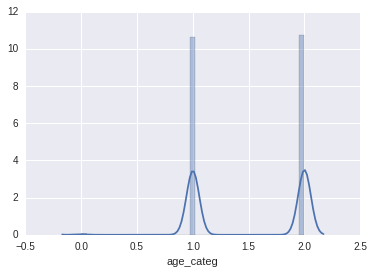

In [51]:
plt.figure(figsize=(6, 4))
sns.distplot(train['age_categ'])

Первое значение встречается подозрительно часто. Может быть это NaN, которые заменили на среднее? Проверим гипотезу

In [52]:
all = pd.concat([train, test])
mask = np.isclose(all['var38'], 117310.979, atol=1e-2)
all.loc[~mask, 'var38'].mean()

117310.979024098

Да, все сходится - организаторы конкурса заменили NaN в этой колонке на среднее. Из этого можно извлечь информацию - можно добавить фичу - is_var38_NaN

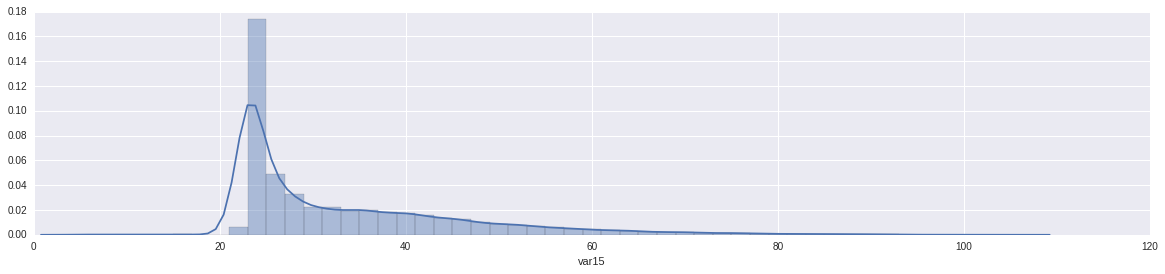

In [53]:
plt.figure(figsize=(20, 4))
pl1 = sns.distplot(train['var15'])

<bound method AxesSubplot.bar of <matplotlib.axes._subplots.AxesSubplot object at 0x7f38ed7f6850>>


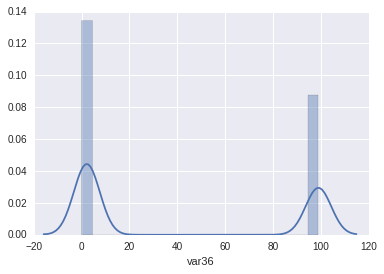

In [54]:
plt.figure(figsize=(6,4))
sns.distplot(train['var36'])

In [55]:
train['var36']

0        99
1         3
2        99
3         2
4         1
5        99
6         3
7         2
8        99
9         2
10        1
11       99
12       99
13        1
14        1
15       99
16       99
17        1
18        1
19        3
20       99
21        3
22        2
23        2
24       99
25        1
26       99
27       99
28       99
29        2
         ..
75990     1
75991     2
75992     3
75993    99
75994     2
75995     2
75996     3
75997     3
75998    99
75999    99
76000     1
76001     3
76002     1
76003     1
76004     3
76005     1
76006     1
76007    99
76008    99
76009     1
76010    99
76011     3
76012     2
76013     1
76014     1
76015    99
76016     2
76017    99
76018    99
76019    99
Name: var36, dtype: int64

Распределение очень напоминает возраст. Из этого тоже можно извлечь информацию - разделить по возрастным группам и т.д.

### ROC AUC

In [129]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://www.unc.edu/courses/2006spring/ecol/145/001/images/lectures/lecture37/fig4.png", width=700, height=700)

In [131]:
Image(url= "https://raw.githubusercontent.com/stevenRush/DMIA/master/santander/pic2.png", width=800, height=80)

In [132]:
Image(url= "https://raw.githubusercontent.com/stevenRush/DMIA/master/santander/pic1.png", width=800, height=80)

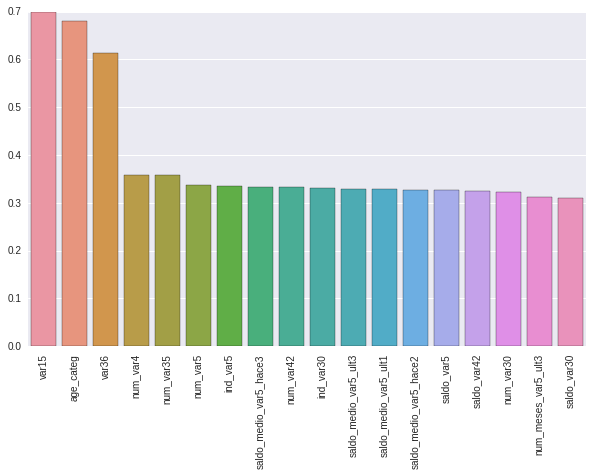

In [56]:
from sklearn.metrics import roc_auc_score

scores = []

for column in train:
    roc_score = roc_auc_score(labels, train[column])
    if abs(roc_score - 0.5) > 0.1:
        scores.append((column, roc_score))
scores = sorted(scores, key=lambda x: x[1], reverse=1)

plt.figure(figsize=(10, 6))
sns.barplot(*zip(*scores))
_ = plt.xticks(rotation=90)

In [57]:
train['var36'].value_counts()

99    30064
3     22177
1     14664
2      8704
0       411
Name: var36, dtype: int64

In [58]:
roc_auc_score(labels, train['var15'])

0.69863990269815746

In [59]:
roc_auc_score(labels, train['age_categ'])

0.68047043381676686

In [60]:
roc_auc_score(labels, train['Is_NaN'])

0.4955597688109562

## Обучим на признаках RandomForest и сделаем посылку

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score, StratifiedKFold

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
cv = StratifiedKFold(labels, n_folds=3)
print cross_val_score(rf, train, labels, scoring='roc_auc', cv=cv).mean()

0.75487737467


In [62]:
print cross_val_score(rf, train, labels, scoring='roc_auc', cv=cv)

[ 0.75259319  0.74202619  0.76762139]


In [30]:
from sklearn.metrics import roc_curve, auc

In [31]:
fpr, tpr, _ = roc_curve(labels, train['age_categ'])
roc_auc = auc(fpr, tpr)


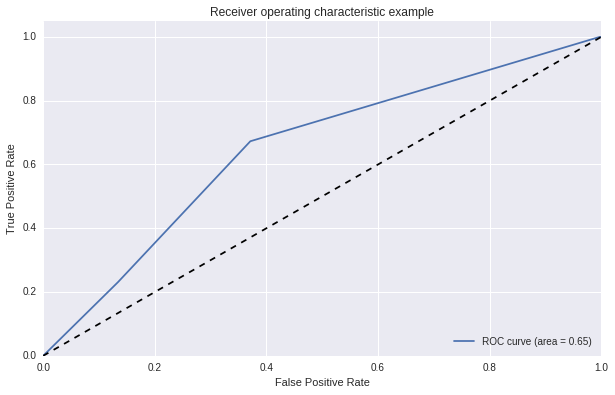

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
rf.fit(train, labels)
preds = rf.predict_proba(test)
submit(preds)

## Идеи для дальнейшей работы

- Удалить константные признаки
- Удалить повторяющиеся признаки
- Добавить новые фичи: например, количество нулей в объекте, признак, связанный с var38, что-нибудь с возрастом
- Попробовать отобрать признаки, например с помощью ROC AUC
- Попробовать добавить новые признаки, проверяя их качество с помощью ROC AUC

## Домашнее задание

- Разобраться с бенчмарком
- Попробовать предложенные идеи
- Попробовать улучшить бенчмарк: новые фичи, идеи и т.д.